## Introduction
In this notebook we will work with the Exploration Wellbore Dataset from Norwegian Petroleum Directorate (NPD). The wellbore datasets are public domain. They are available here: https://data.norge.no/data/oljedirektoratet/br%C3%B8nnbane-wellbore. <br> <br>
The datasets are available via an API. We will use this option (get request) to avoid downloading our dataset locally. The datasets are regularly updated, therefore by using the API, we only have to re run our code and get the updates in our graphs. <br>
We will generate several stack bar graphs, using the ALTAIR library. The graphs will show us:
1. Status of all Exploration wells on the Norwegian Shelf since beginning of exploration, by year, number of wells and well content (oil/gas/condensate or any combination)
2. Status of Exploration wells between 1980 and 2019, by region: NORTH SEA, NORWEGIAN SEA and BARENTS SEA

We wished to make this notebook easy to follow so that anybody could understand the different steps of data wrangling to finally the stack bar graphs. 

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

#### API connection - check for status
Make a general get request, print out status code.
Status code = 200 means API connection is up and running.

In [2]:
response = requests.get('http://data.norge.no/api/dcat/870917732/data.json')

status_code = response.status_code
print(status_code)

200


#### Get request - Exploration dataset
The datasets are paginated. The first page will tell us how many pages there are in total, and how many rows for the whole dataset.

In [3]:
dataset_explo = requests.get('http://hotell.difi.no/api/json/npd/wellbore/exploration?page=1')
json_dataset_explo = dataset_explo.json()

In [4]:
print('number of pages:') 
print(json_dataset_explo['pages']) 
print()
print ('number of rows:')
print(json_dataset_explo['posts'])

number of pages:
20

number of rows:
1910


#### Let's go through all the pages and append all the rows in a JSON file
Create a pandas dataframe from the json file

In [5]:
page = json_dataset_explo['pages']
all_data_list_explo = []
for i in range(0, page):
    url =f'http://hotell.difi.no/api/json/npd/wellbore/exploration?page={i+1}'

    dataset_all_explo = requests.get(url)
    dataset_all_explo_json = dataset_all_explo.json()
    number_of_entries = len(dataset_all_explo_json['entries'])

    for x in range(0, number_of_entries):
        all_data_list_explo.append(dataset_all_explo_json['entries'][x])

In [6]:
df_all_explo = pd.DataFrame(all_data_list_explo)
# df_all_explo.head()

In [7]:
df_all_explo.shape

(1910, 81)

In [8]:
# df_all_explo.columns

#### Select columns out in a new dataframe (from 81 columns down to 22)

In [8]:
# select only a few columns
df_all_explo_extract_col = df_all_explo.filter(['wlbWellboreName', 'wlbEwDesDeg','wlbNsDecDeg', 'wlbEntryYear',
                                                'wlbCompletionYear','wlbEwUtm','wlbNsUtm','wlbUtmZone',
                                                'wlbContent', 'wlbDiscoveryWellbore',
                                                'wlbTotalDepth','wlbAgeAtTd','wlbFormationAtTd',
                                                'wlbAgeWithHc1', 'wlbAgeWithHc2', 'wlbAgeWithHc3',
                                                'wlbFormationWithHc1', 'wlbFormationWithHc2', 'wlbFormationWithHc3',
                                                'wlbDrillingOperator', 'wlbMainArea', 'datesyncNPD'],
                                                axis=1)

In [9]:
df_all_explo_extract_col.head()

,wlbWellboreName,wlbEwDesDeg,wlbNsDecDeg,wlbEntryYear,wlbCompletionYear,wlbEwUtm,wlbNsUtm,wlbUtmZone,wlbContent,wlbDiscoveryWellbore,...,wlbFormationAtTd,wlbAgeWithHc1,wlbAgeWithHc2,wlbAgeWithHc3,wlbFormationWithHc1,wlbFormationWithHc2,wlbFormationWithHc3,wlbDrillingOperator,wlbMainArea,datesyncNPD
0,1/2-1,2.476583,56.887519,1989,1989,468106.29,6305128.26,31,OIL,YES,...,TOR FM,PALEOCENE,,,FORTIES FM,,,Phillips Petroleum Norsk AS,NORTH SEA,03.09.2019
1,1/2-2,2.496572,56.992222,2005,2006,469410.10,6316774.33,31,OIL SHOWS,NO,...,EKOFISK FM,,,,,,,Paladin Resources Norge AS,NORTH SEA,03.09.2019
2,1/3-1,2.851389,56.855833,1968,1968,490936.87,6301488.86,31,GAS,YES,...,ZECHSTEIN GP,LATE CRETACEOUS,EARLY CRETACEOUS,,TOR FM,CROMER KNOLL GP,,A/S Norske Shell,NORTH SEA,03.09.2019
3,1/3-2,2.750000,56.936111,1969,1969,484786.28,6310443.20,31,DRY,NO,...,SOLA FM,,,,,,,A/S Norske Shell,NORTH SEA,03.09.2019
4,1/3-3,2.981681,56.952378,1982,1983,498885.66,6312226.32,31,OIL,YES,...,ZECHSTEIN GP,LATE JURASSIC,,,ULA FM,,,Elf Petroleum Norge AS,NORTH SEA,03.09.2019


---

# Working with Altair bar graphs

#### Building a stack graph bar with exploration wells, grouped by well entry year (x axis), total number of well per year (y axis), and colour code for oil/gas/condensate/dry (or a combination of these)

In [10]:
# replace all empty values ('') in dataframe with 'nan'
df_all_explo_extract_col = df_all_explo_extract_col.replace('', np.nan)

In [11]:
df_all_explo_extract_col.shape

(1910, 22)

Let's check how many 'Wellbore Content' categories we have in the whole dataset, with a count per category:

In [12]:
df_all_explo_extract_col.wlbContent.unique()

array(['OIL', 'OIL SHOWS', 'GAS', 'DRY', 'GAS/CONDENSATE', 'SHOWS',
       'OIL/GAS', 'NOT APPLICABLE', 'GAS SHOWS', 'OIL/GAS SHOWS', nan,
       'OIL/GAS/CONDENSATE', 'NOT AVAILABLE'], dtype=object)

In [13]:
df_all_explo_extract_col['wlbContent'].nunique()

12

In [14]:
df_all_explo_extract_col[['wlbEntryYear','wlbContent']].groupby('wlbContent').agg(['count'])

,wlbEntryYear
,count
wlbContent,
DRY,502
GAS,149
GAS SHOWS,16
GAS/CONDENSATE,155
NOT APPLICABLE,44
NOT AVAILABLE,1
OIL,478
OIL SHOWS,76


In [15]:
# show how many 'NaN' entries for each column
df_all_explo_extract_col.isna().sum()

wlbWellboreName            0
wlbEwDesDeg                0
wlbNsDecDeg                0
wlbEntryYear               0
wlbCompletionYear          0
wlbEwUtm                   0
wlbNsUtm                   0
wlbUtmZone                 0
wlbContent                39
wlbDiscoveryWellbore       0
wlbTotalDepth              0
wlbAgeAtTd                77
wlbFormationAtTd         143
wlbAgeWithHc1            819
wlbAgeWithHc2           1505
wlbAgeWithHc3           1843
wlbFormationWithHc1      868
wlbFormationWithHc2     1520
wlbFormationWithHc3     1846
wlbDrillingOperator        0
wlbMainArea                0
datesyncNPD                0
dtype: int64

We are removing rows with 'NaN' in 'Wellbore Content'...

In [16]:
# removing all wlbContent with NaN
df_all_explo_extract_col = df_all_explo_extract_col[pd.notnull(df_all_explo_extract_col['wlbContent'])]

In [17]:
df_all_explo_extract_col.shape

(1871, 22)

#### Let's QC the years in our dataset - do we have any values for years which are not relevant?

In [18]:
# what is my minimum entry year?
df_all_explo_extract_col['wlbEntryYear'].min()

'0'

In [19]:
# what is my maximum entry year?
df_all_explo_extract_col['wlbEntryYear'].max()

'2019'

In [20]:
# how many entry years = 0?
df_all_explo_extract_col[['wlbEntryYear']].eq('0').sum()

wlbEntryYear    1
dtype: int64

#### We found one row with year = 0. Let's remove this row from our dataset.

In [21]:
# remove all rows with entry year = 0
df_all_explo_extract_col = df_all_explo_extract_col[df_all_explo_extract_col.wlbEntryYear != '0']

In [22]:
df_all_explo_extract_col.shape

(1870, 22)

#### Let's clean out 'Wellbore Content' values 'NOT APPLICABLE', 'NOT AVAILABLE', 'SHOWS', 'WATER' to have a more readable graph

In [23]:
df_all_explo_extract_col = df_all_explo_extract_col[df_all_explo_extract_col['wlbContent'].isin([
          'NOT APPLICABLE', 'SHOWS', 'WATER', 'NOT AVAILABLE']) == False]

In [24]:
df_all_explo_extract_col.shape

(1689, 22)

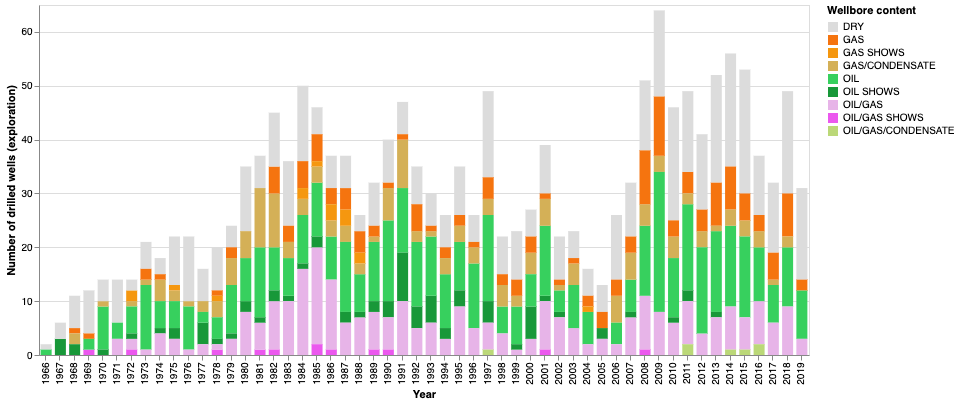

In [25]:
# Bar chart for number of drilled wells - exploration
chart = alt.Chart(df_all_explo_extract_col).mark_bar(size=11).encode(
    x=alt.X('wlbEntryYear:N', axis=alt.Axis(title='Year')),
    y=alt.Y('count()', axis=alt.Axis(title='Number of drilled wells (exploration)')),
    
    color=alt.Color('wlbContent', scale=alt.Scale(range=['#DCDCDC','#F5740F','#F5970F','#D4B057','#37D05E',
                                                        '#189839','#E7B4E8','#EB58EE','#BBD878', '#898989']),
                   legend=alt.Legend(title="Wellbore content"))
).properties(
    width=770,
    height=350
 )
chart 

---

#### Next, we would like to create three different bar graphs for North Sea, Norwegian Sea and Barents Sea, showing years 1980 to 2019

'wlbEntryYear' has type 'Object'. To be able to select years from 1980 to 2019, wlbEntryYear has to be converted in int64. <br><br>
Let's reduce the number of columns in the dataframe df_all_explo_extract_col and create a new dataframe df_all_explo_extract_col_years

In [26]:
df_all_explo_extract_col_years = df_all_explo_extract_col.filter(['wlbWellboreName','wlbEntryYear',
                                                'wlbCompletionYear',
                                                'wlbContent', 'wlbDiscoveryWellbore',
                                                'wlbTotalDepth','wlbAgeAtTd','wlbFormationAtTd',
                                                'wlbDrillingOperator', 'wlbMainArea', 'datesyncNPD'],
                                                axis=1)

In [27]:
df_all_explo_extract_col_years['wlbEntryYear'] = df_all_explo_extract_col_years['wlbEntryYear'].astype('int64')

In [29]:
# df_all_explo_extract_col_years.dtypes

---

In [28]:
# let's find out the wlbEntryYear min and max for North Sea (NTS)
df_all_explo_extract_col_years_NTS = df_all_explo_extract_col_years[
    df_all_explo_extract_col_years.wlbMainArea == 'NORTH SEA']

year_min_NTS = df_all_explo_extract_col_years_NTS['wlbEntryYear'].min()
year_max_NTS = df_all_explo_extract_col_years_NTS['wlbEntryYear'].max()
print(year_min_NTS)
print(year_max_NTS)

1966
2019


In [29]:
# let's find out the wlbEntryYear min and max for Norwegian Sea (NS)
df_all_explo_extract_col_years_NS = df_all_explo_extract_col_years[
    df_all_explo_extract_col_years.wlbMainArea == 'NORWEGIAN SEA']

year_min_NS = df_all_explo_extract_col_years_NS['wlbEntryYear'].min()
year_max_NS = df_all_explo_extract_col_years_NS['wlbEntryYear'].max()
print(year_min_NS)
print(year_max_NS)

1980
2019


In [30]:
# let's find out the wlbEntryYear min and max for Barents Sea (BS)
df_all_explo_extract_col_years_BS = df_all_explo_extract_col_years[
    df_all_explo_extract_col_years.wlbMainArea == 'BARENTS SEA']

year_min_BS = df_all_explo_extract_col_years_BS['wlbEntryYear'].min()
year_max_BS = df_all_explo_extract_col_years_BS['wlbEntryYear'].max()
print(year_min_BS)
print(year_max_BS)

1980
2019


---

In [31]:
# select from df_all_explo_extract_col, years 1980 to 2019
df_all_explo_extract_col_1980_2019 = df_all_explo_extract_col_years.query('1980 <= wlbEntryYear <= 2019').copy()

In [32]:
df_all_explo_extract_col_1980_2019.shape

(1473, 11)

In [33]:
df_all_explo_extract_col_1980_2019.head()

,wlbWellboreName,wlbEntryYear,wlbCompletionYear,wlbContent,wlbDiscoveryWellbore,wlbTotalDepth,wlbAgeAtTd,wlbFormationAtTd,wlbDrillingOperator,wlbMainArea,datesyncNPD
0,1/2-1,1989,1989,OIL,YES,3574.0,CAMPANIAN,TOR FM,Phillips Petroleum Norsk AS,NORTH SEA,03.09.2019
1,1/2-2,2005,2006,OIL SHOWS,NO,3434.0,PALEOCENE,EKOFISK FM,Paladin Resources Norge AS,NORTH SEA,03.09.2019
4,1/3-3,1982,1983,OIL,YES,4876.0,LATE PERMIAN,ZECHSTEIN GP,Elf Petroleum Norge AS,NORTH SEA,03.09.2019
5,1/3-4,1983,1983,OIL SHOWS,NO,3198.0,LATE PERMIAN,ZECHSTEIN GP,Elf Petroleum Norge AS,NORTH SEA,03.09.2019
6,1/3-5,1984,1985,DRY,NO,4850.0,EARLY PERMIAN,ROTLIEGEND GP,A/S Norske Shell,NORTH SEA,03.09.2019


In [34]:
year_min = df_all_explo_extract_col_1980_2019['wlbEntryYear'].min()
year_max = df_all_explo_extract_col_1980_2019['wlbEntryYear'].max()
print(year_min)
print(year_max)

1980
2019


In [35]:
df_all_explo_extract_col_1980_2019.dtypes

wlbWellboreName         object
wlbEntryYear             int64
wlbCompletionYear       object
wlbContent              object
wlbDiscoveryWellbore    object
wlbTotalDepth           object
wlbAgeAtTd              object
wlbFormationAtTd        object
wlbDrillingOperator     object
wlbMainArea             object
datesyncNPD             object
dtype: object

In [36]:
# re-index df_all_explo_extract_col_1980_2019
df_all_explo_extract_col_1980_2019 = df_all_explo_extract_col_1980_2019.reset_index(drop=True)

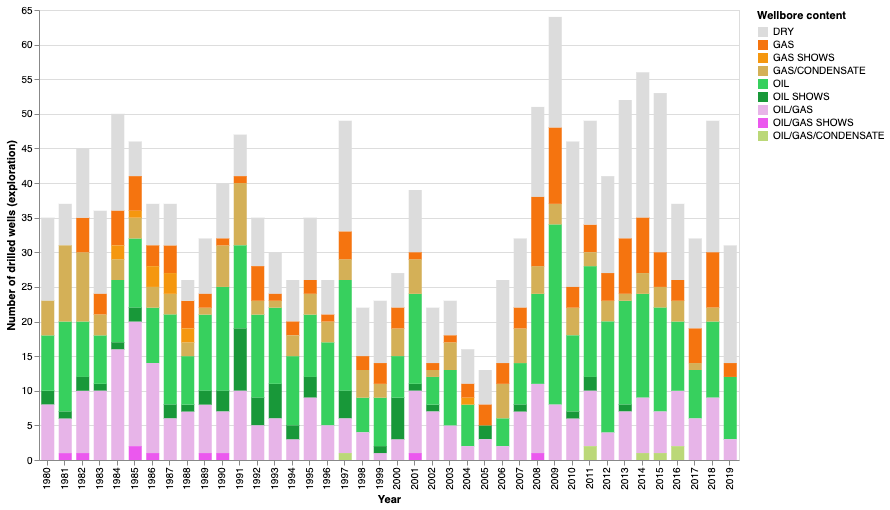

In [37]:
# redrawing chart showing years 1980 to 2019 only
chart2 = alt.Chart(df_all_explo_extract_col_1980_2019).mark_bar(size=13).encode(

    x=alt.X('wlbEntryYear:N', axis=alt.Axis(title='Year')),
    y=alt.Y('count()', axis=alt.Axis(title='Number of drilled wells (exploration)')),
    
    color=alt.Color('wlbContent', scale=alt.Scale(range=['#DCDCDC','#F5740F','#F5970F','#D4B057','#37D05E',
                                                        '#189839','#E7B4E8','#EB58EE','#BBD878', '#898989']),
                   legend=alt.Legend(title='Wellbore content'))
).properties(
     width=700,
     height=450
 )
chart2

Let's now create a new dataframe for each region (North Sea, Norwegian Sea and Barents Sea), and then create a graph for each.

In [38]:
df_all_explo_extract_col_1980_2019[['wlbWellboreName','wlbMainArea']].groupby('wlbMainArea').agg(['count'])

,wlbWellboreName
,count
wlbMainArea,
BARENTS SEA,141
NORTH SEA,1010
NORWEGIAN SEA,322


Create a new dataframe with North Sea region only, <br>
Drawing graph for NORTH SEA, 1980-2019

In [39]:
df_all_explo_extract_col_1980_2019_NTS = df_all_explo_extract_col_1980_2019[df_all_explo_extract_col_1980_2019[
    'wlbMainArea'].str.match('NORTH SEA')]

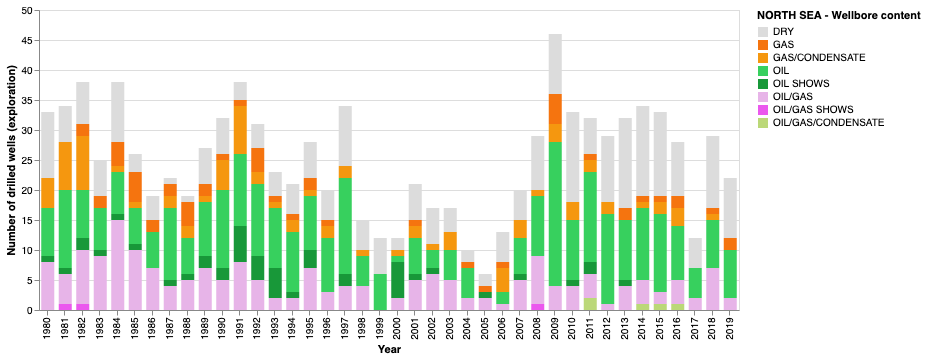

In [40]:
chart3 = alt.Chart(df_all_explo_extract_col_1980_2019_NTS).mark_bar(size=13).encode(

    x=alt.X('wlbEntryYear:N', axis=alt.Axis(title='Year')),
    y=alt.Y('count()', axis=alt.Axis(title='Number of drilled wells (exploration)')),
    
    color=alt.Color('wlbContent', scale=alt.Scale(range=['#DCDCDC','#F5740F','#F5970F','#37D05E',
                                                        '#189839','#E7B4E8','#EB58EE','#BBD878','#898989']),
                   legend=alt.Legend(title='NORTH SEA - Wellbore content'))
).properties(
     width=700,
     height=300
 )
chart3

Create a new dataframe with Norwegian Sea region only, <br>
Drawing graph for NORWEGIAN SEA, 1980-2019

In [41]:
df_all_explo_extract_col_1980_2019_NS = df_all_explo_extract_col_1980_2019[df_all_explo_extract_col_1980_2019[
    'wlbMainArea'].str.match('NORWEGIAN SEA')]

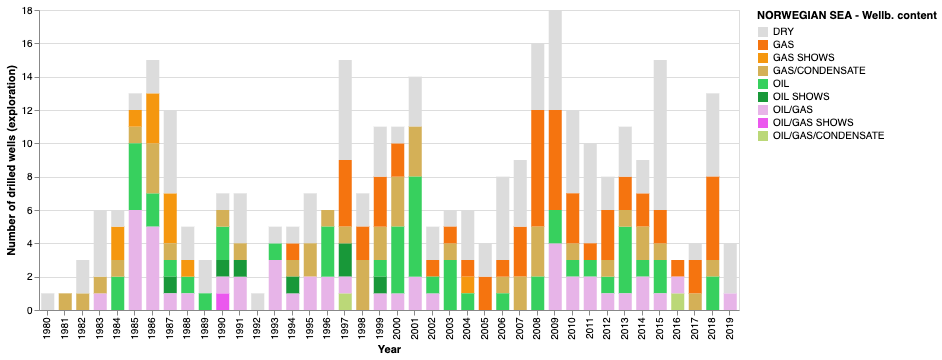

In [42]:
chart4 = alt.Chart(df_all_explo_extract_col_1980_2019_NS).mark_bar(size=13).encode(

    x=alt.X('wlbEntryYear:N', axis=alt.Axis(title='Year')),
    y=alt.Y('count()', axis=alt.Axis(title='Number of drilled wells (exploration)')),
    
    color=alt.Color('wlbContent', scale=alt.Scale(range=['#DCDCDC','#F5740F','#F5970F','#D4B057','#37D05E',
                                                        '#189839','#E7B4E8','#EB58EE','#BBD878','#898989']),
                   legend=alt.Legend(title='NORWEGIAN SEA - Wellb. content'))
).properties(
     width=700,
     height=300
 )
chart4

Create a new dataframe with Barents Sea region only, <br>
Drawing graph for BARENTS SEA, 1980-2019

In [43]:
df_all_explo_extract_col_1980_2019_BS = df_all_explo_extract_col_1980_2019[df_all_explo_extract_col_1980_2019[
    'wlbMainArea'].str.match('BARENTS SEA')]

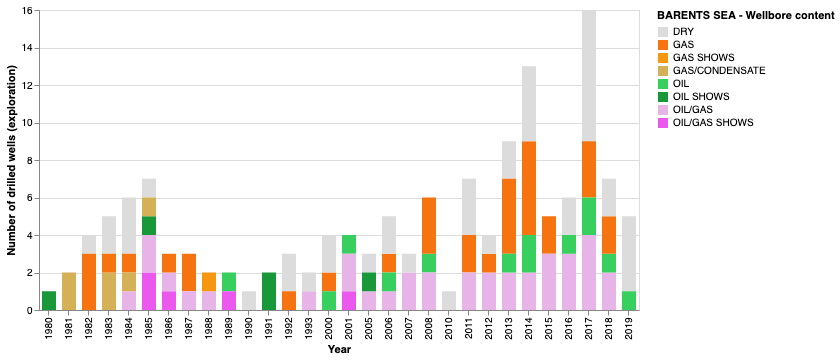

In [44]:
chart5 = alt.Chart(df_all_explo_extract_col_1980_2019_BS).mark_bar(size=14).encode(

    x=alt.X('wlbEntryYear:N', axis=alt.Axis(title='Year')),
    y=alt.Y('count()', axis=alt.Axis(title='Number of drilled wells (exploration)')),
    
    color=alt.Color('wlbContent', scale=alt.Scale(range=['#DCDCDC','#F5740F','#F5970F','#D4B057','#37D05E',
                                                        '#189839','#E7B4E8','#EB58EE','#BBD878','#898989']),
                   legend=alt.Legend(title='BARENTS SEA - Wellbore content'))
).properties(
     width=600,
     height=300
 )
chart5

In [47]:
# EOF